      MPG  Cylinders  Displacement  Horsepower  Weight  Acceleration  \
393  27.0          4         140.0        86.0  2790.0          15.6   
394  44.0          4          97.0        52.0  2130.0          24.6   
395  32.0          4         135.0        84.0  2295.0          11.6   
396  28.0          4         120.0        79.0  2625.0          18.6   
397  31.0          4         119.0        82.0  2720.0          19.4   

     Model Year  Origin  
393          82       1  
394          82       2  
395          82       1  
396          82       1  
397          82       1  
MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64
              count         mean         std     min      25%     50%  \
Cylinders     314.0     5.477707    1.699788     3.0     4.00     4.0   
Displacement  314.0   195.318471  104.331589    68.0   105.50   151.0   
Horsepower    314.0   104.869427   

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[[ 0.01796322]
 [ 0.08754285]
 [-0.17274594]
 [ 0.09765515]
 [-0.23765543]
 [ 0.15524678]
 [-0.17101085]
 [-0.5522847 ]
 [ 0.1507563 ]
 [ 0.26719677]]

....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
........................................

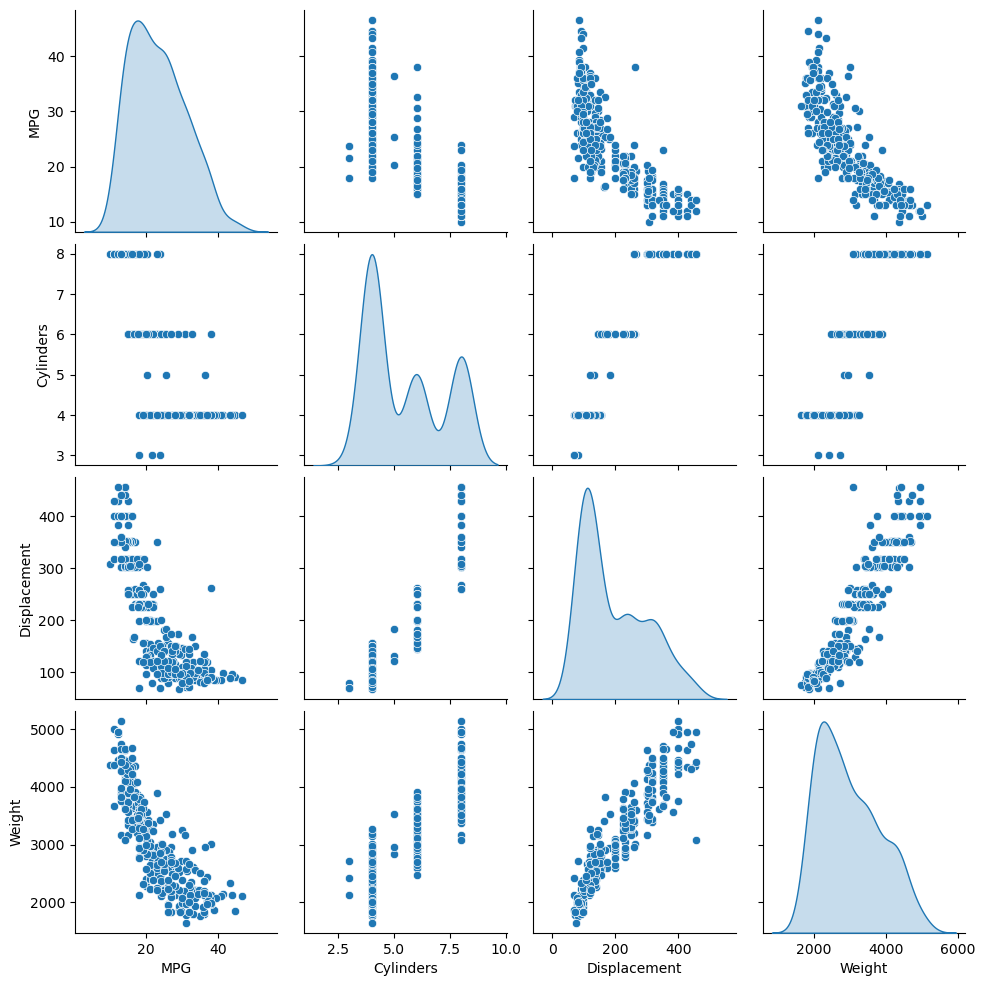

In [11]:
import pathlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names = column_names, na_values = "?", comment='\t', sep = " " , skipinitialspace = True)
dataset = raw_dataset.copy()
print(dataset.tail())

print(dataset.isnull().sum())
dataset = dataset.dropna()

origin = dataset.pop('Origin')
dataset['USA'] = (origin==1)*1.0
dataset['Europe'] = (origin==2)*1.0
dataset['Japan'] = (origin==3)*1.0
dataset.tail()

train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

train_stats = train_dataset.describe()
train_stats.pop("MPG")

train_stats = train_stats.transpose()
print(train_stats)

train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

def norm(x):
    return(x-train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

model = tf.keras.Sequential()
model.add(keras.layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(1))
optimizer = tf.keras.optimizers.RMSprop(0.001)

model.compile(loss='mse', optimizer = optimizer, metrics=['mae', 'mse'])

example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
print(example_result)

class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch%100==0:
            print('')
        print('.', end='')
EPOCHS = 1000

history = model.fit(normed_train_data, train_labels, epochs = EPOCHS, validation_split = 0.2, verbose= 0, callbacks=[PrintDot()])

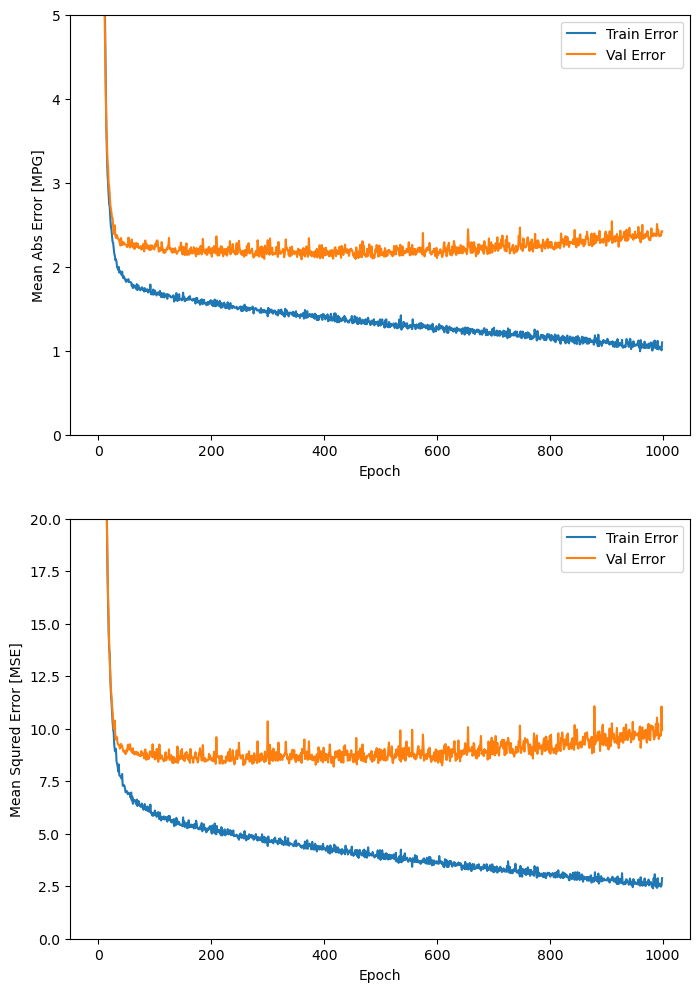

In [13]:
import matplotlib.pyplot as plt

def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    plt.figure(figsize=(8, 12))

    plt.subplot(2, 1, 1)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mae'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'], label='Val Error')
    plt.ylim([0, 5])
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squred Error [MSE]')
    plt.plot(hist['epoch'], hist['mse'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'], label='Val Error')
    plt.ylim([0, 20])
    plt.legend()

    plt.show()

plot_history(history)


.............

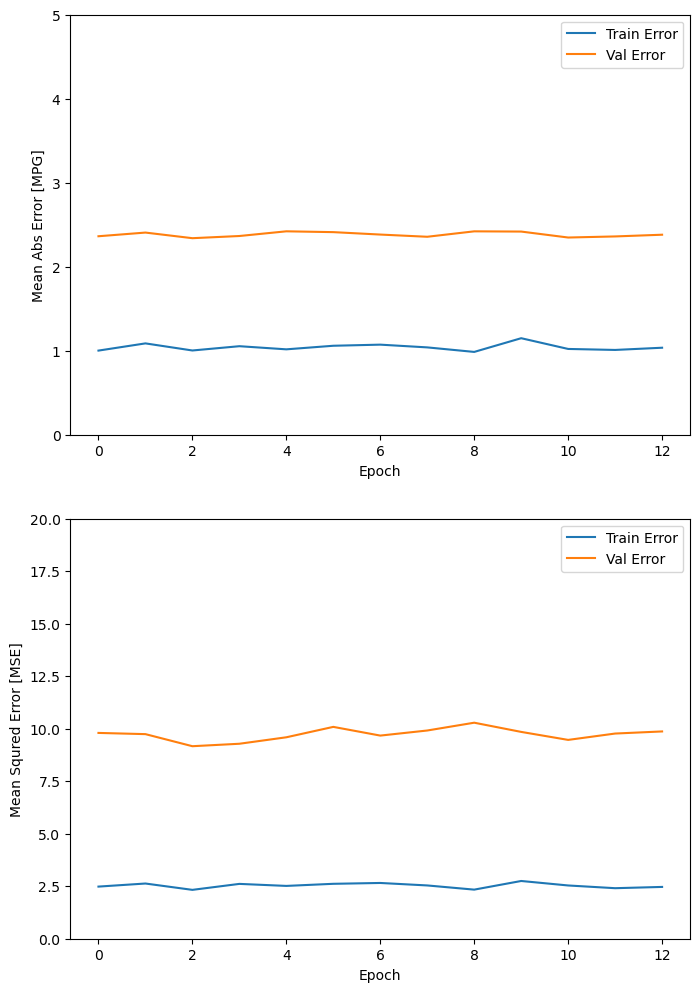

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
실제 최소 = 11.6265287399292, 실제 최대 = 40.86391830444336, 오차 평균 = 2.1544633889809632
예상 최소 = 9.0, 실제 최대 = 44.3


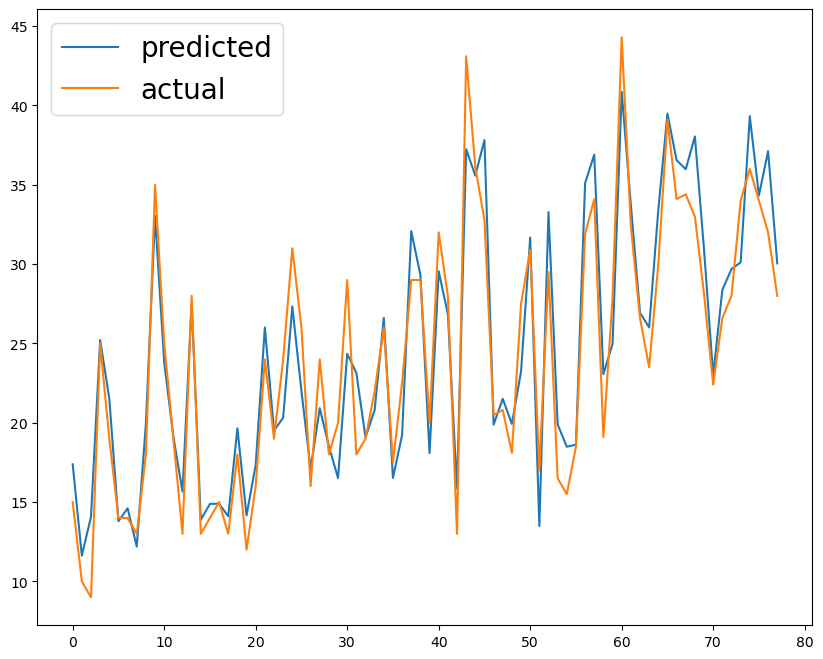

In [15]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience = 10)
history = model.fit(normed_train_data, train_labels, epochs=EPOCHS, validation_split = 0.2, verbose = 0, callbacks=[early_stop, PrintDot()])
plot_history(history)

Y_prediction = model.predict(normed_test_data).flatten()
plt.figure(figsize=(10, 8))
plt.plot(Y_prediction, label='predicted')
plt.plot(test_labels.values, label='actual')
plt.legend(prop={'size':20})

avr = abs(Y_prediction - test_labels).mean()
print(f'실제 최소 = {min(Y_prediction)}, 실제 최대 = {max(Y_prediction)}, 오차 평균 = {avr}')
print(f'예상 최소 = {min(test_labels)}, 실제 최대 = {max(test_labels)}')